### Data wrangle

In [2]:
# Grab Data
import yfinance as yf

# Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Use PyPortfolioOpt for Calculations
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation

In [3]:
# Create a Portfolio
symbols = ['PFE','GSK','AZN','BMY','MRK','RHHBY','SNY','NVS','ABBV','JNJ']

In [4]:
# Get the stock data
portfolio = yf.download(symbols, start="2000-01-01", end="2024-02-29")['Adj Close']
portfolio.head()

[*********************100%%**********************]  10 of 10 completed


Ticker,ABBV,AZN,BMY,GSK,JNJ,MRK,NVS,PFE,RHHBY,SNY
Date,,,,,,,,,,
2000-01-03,NaN,8.473516,25.552828,18.336876,24.698616,26.704514,15.261842,13.061073,NaN,NaN
2000-01-04,NaN,8.190207,23.619625,17.862463,23.794407,25.766647,14.973387,12.574480,NaN,NaN
2000-01-05,NaN,8.228837,23.468325,18.460630,24.045568,26.778532,15.038946,12.779360,NaN,NaN
2000-01-06,NaN,8.203085,23.791842,18.192486,24.799097,27.000671,15.366735,13.240336,NaN,NaN
2000-01-07,NaN,8.550785,27.275997,19.141306,25.854000,29.592150,15.602741,14.136684,NaN,NaN


In [5]:
# SP500 ETF Benchmark
market_prices = yf.download("SPY", start="2000-01-01", end="2024-02-29")["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2000-01-03    93.591164
2000-01-04    89.931137
2000-01-05    90.092018
2000-01-06    88.644142
2000-01-07    93.792191
Name: Adj Close, dtype: float64

In [6]:
# Grap Market Capitalization for each stock in portfolio
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'PFE': 157305356288,
 'GSK': 87829864448,
 'AZN': 211633995776,
 'BMY': 107681611776,
 'MRK': 333675331584,
 'RHHBY': 201586933760,
 'SNY': 123674140672,
 'NVS': 195996925952,
 'ABBV': 319336742912,
 'JNJ': 380648849408}

### Setting up priors

In [7]:
# Calculate Sigma and Delta to get implied market returns
# Ledoit-Wolf is a particular form of shrinkage, where the shrinkage coefficient is computed using O?
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

1.8014970426291426

<Axes: xlabel='Ticker', ylabel='Ticker'>

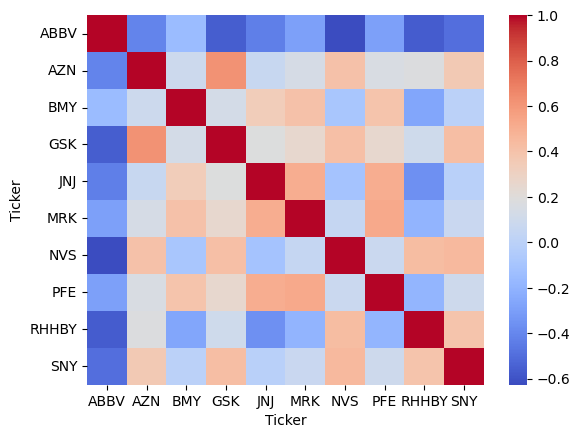

In [8]:
# Visualize the Covariant Correlation
sns.heatmap(S.corr(), cmap='coolwarm')

In [9]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
ABBV     0.044050
AZN      0.070708
BMY      0.066284
GSK      0.063854
JNJ      0.059515
MRK      0.075278
NVS      0.059303
PFE      0.069455
RHHBY    0.053936
SNY      0.065361
dtype: float64

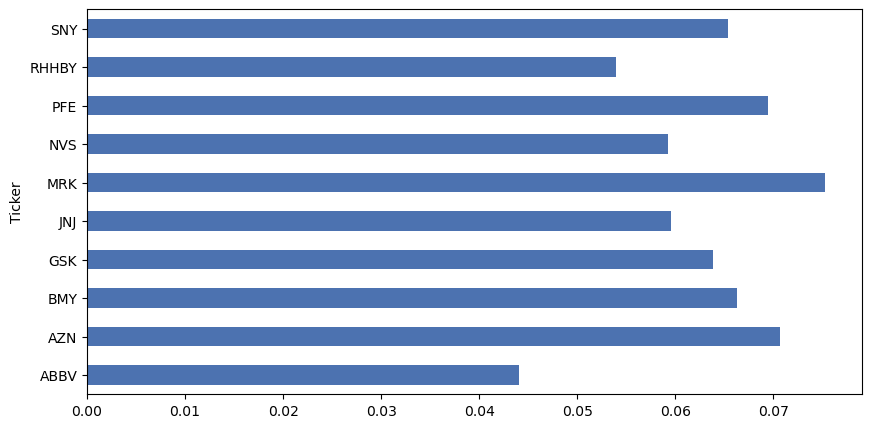

In [10]:
# What am I looking at here?
market_prior.plot.barh(figsize=(10,5));

### Integrating views

In [11]:
#You don't have to provide views on all the assets
viewdict = {'PFE': 0.1,
            'GSK': 0.1,
            'AZN': -0.05,
            'BMY': 0.28,
            'MRK': 0.09,
            'RHHBY': -0.12,
            'SNY': 0.07,
            'NVS': -0.25,
            'ABBV': 0.21,
            'JNJ': 0.2}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

#### Creating confidences

We can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [12]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.03, 0.1),
    (-0.1, 0),
    (0.1, 0.2),
    (-0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [13]:
variances = []
for lb, ub in intervals: # lb: lower bound, ub: upper bound
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0012250000000000002, 0.0025000000000000005, 0.0025000000000000005, 0.010000000000000002, 0.16000000000000003, 0.0225]


### Calculate Posterior Estimate Returns

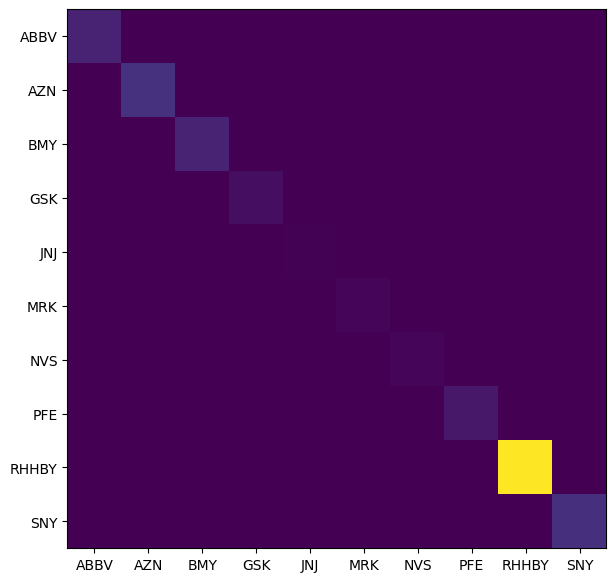

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [15]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [16]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
ABBV     0.028833
AZN      0.033222
BMY      0.125362
GSK      0.042511
JNJ      0.057587
MRK      0.083931
NVS     -0.002614
PFE      0.069755
RHHBY   -0.032047
SNY      0.043800
dtype: float64

In [17]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
ABBV,0.044050,0.028833,0.21
AZN,0.070708,0.033222,-0.05
BMY,0.066284,0.125362,0.28
GSK,0.063854,0.042511,0.10
JNJ,0.059515,0.057587,0.20
MRK,0.075278,0.083931,0.09
NVS,0.059303,-0.002614,-0.25
PFE,0.069455,0.069755,0.10
RHHBY,0.053936,-0.032047,-0.12
SNY,0.065361,0.043800,0.07


<Axes: >

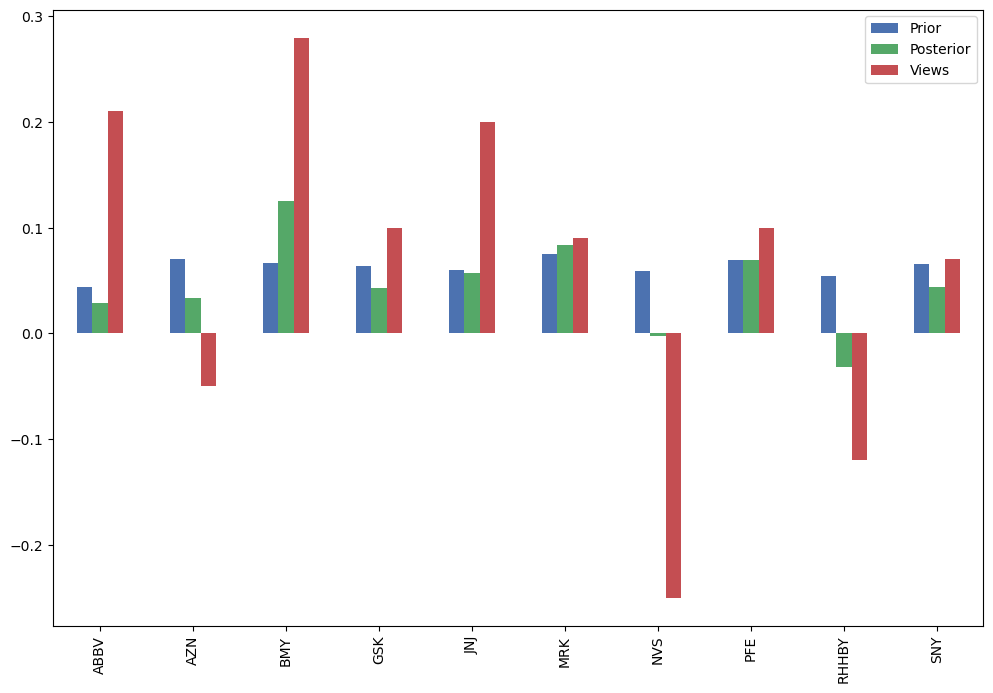

In [18]:
rets_df.plot.bar(figsize=(12,8))

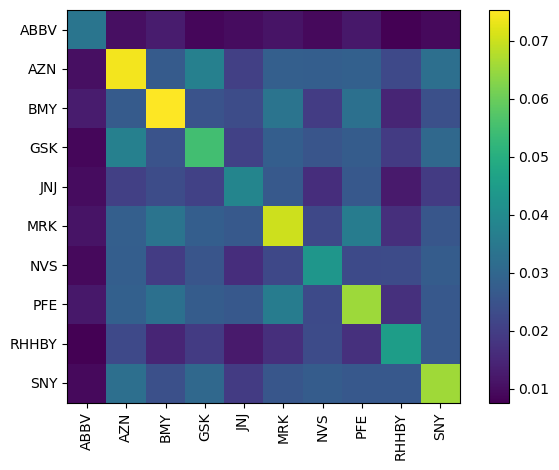

In [19]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

### Portfolio allocation

In [20]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('ABBV', 0.02179),
             ('AZN', 0.02225),
             ('BMY', 0.35692),
             ('GSK', 0.05848),
             ('JNJ', 0.11815),
             ('MRK', 0.20493),
             ('NVS', 0.0),
             ('PFE', 0.15366),
             ('RHHBY', 0.0),
             ('SNY', 0.06382)])

<Axes: >

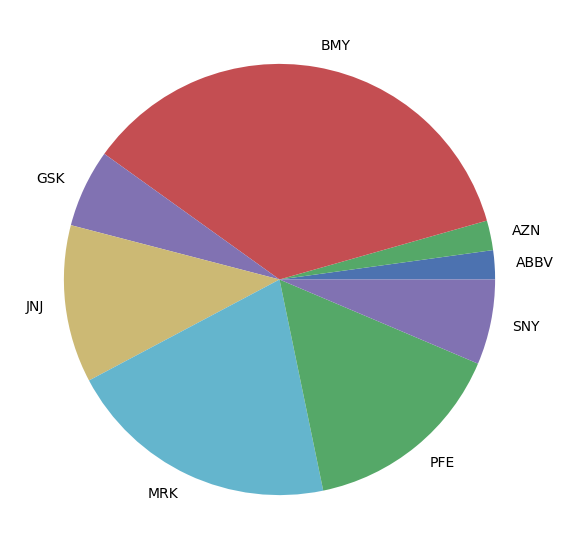

In [23]:
pd.Series(weights).plot.pie(figsize=(7,7))

Expected annual return: 8.6%
Annual volatility: 19.3%
Sharpe Ratio: 0.34


c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
c:\Users\JoyChang\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.08611508062110215, 0.19250816948033408, 0.3434403890472618)

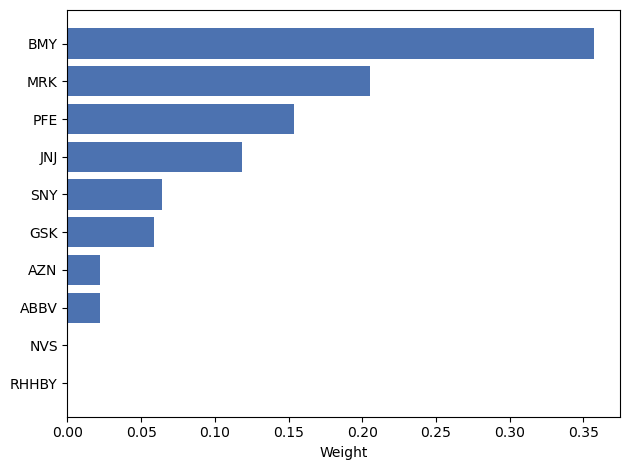

In [22]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)

In [ ]:
import torch

In [ ]:
# Extract the posterior estimate returns from the Black-Litterman model
posterior_returns = ret_bl.values

# Convert the posterior returns to a torch tensor
posterior_returns_tensor = torch.tensor(posterior_returns).float()

# Concatenate the posterior returns with the existing training features (train_x)
# Assuming train_x is already defined as a torch tensor
train_x_with_bl = torch.cat((train_x, posterior_returns_tensor.unsqueeze(0).repeat(train_x.size(0), 1)), dim=1)

# Now train_x_with_bl contains both the historical stock prices and the posterior returns

# Proceed with training the LSTM model using train_x_with_bl
# Update your LSTM model definition and training loop to handle the additional features
# Ensure that the input size of your LSTM model matches the combined feature size

# For example, if your LSTM model expects input size of (batch_size, seq_len, input_size),
# you would need to update the input size to accommodate the additional features
# e.g., input_size = num_features + num_posterior_returns
